# K-Means Clustering in Python
***
K-means clustering is a clustering algorithm that aims to partition n observations into k clusters

There are three steps:
1. Initialisation - K initial "means" (centroids) are generated at random
2. Assignment - K clusters are created by associating each observation with the nearest centroid
3. Update - the hcentroid of the clusters becomes the new mean

Assignment and Update are repeated iteratively until covnergence.

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

In [197]:
data = pd.DataFrame({
    'x': [12, 20, 28, 18, 29, 33, 24, 45, 45, 52, 51, 52, 55, 53, 55, 61, 64, 69, 72],
    'y': [39, 36, 30, 52, 54, 46, 55, 59, 63, 70, 66, 63, 58, 23, 14, 8, 19, 7, 24]
})

## Initialization
***

Set the random seed so it reproducible, and randomly generate the initial centroids for each of the clusters

In [198]:
np.random.seed(1)
k = 3

centroid_colors = {0:'r',1:'g',2:'b'}

centroids = pd.DataFrame({ 'x' : [np.random.randint(0,80) for i in range(k)] , 
                           'y' : [np.random.randint(0,80) for i in range(k)],
                           'color': ['r','g','b'] })
centroids

,color,x,y
0,r,37,9
1,g,12,75
2,b,72,5


Plot the initial data and the initial locations for the centroids

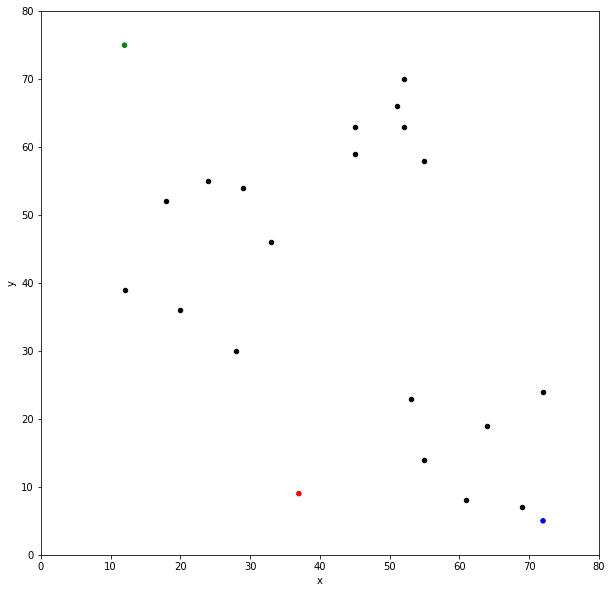

In [199]:
fig, ax1 = plt.subplots(1, figsize=(10,10))

data.plot(kind='scatter',x='x',y='y',color='k',ax=ax1)
centroids.plot(kind='scatter',x='x',y='y',color=centroids['color'],ax=ax1)
    
plt.xlim(0,80)
plt.ylim(0,80)
plt.show()

## Assignment Stage

In [200]:
def assignment( data , centroids ):
    """
    Inputs:
    data - DataFrame containing data
    centroids - dictionary of lists containing centroids 
    
    Returns:
    updated_data - DataFrame with updated data 
    """      
    norm_of_rows = partial( np.linalg.norm , axis=1 , ord=2 )
    
    for i in range(k):
        # each centroid vector is broadcasted to subtract from each row of the data
        # need axis = 1 so the norm of each row is computed and not the norm of entire list of vectors
        data['distance_from_centroid_{}'.format(i)] = \
        norm_of_rows( data[['x','y']] - centroids[['x','y']].iloc[i] , axis=1 )
        
    distance_col_names = ['distance_from_centroid_{}'.format(i) for i in range(k)]
    # argmin over the columns
    data['closest'] = data.loc[: , distance_col_names].idxmin( axis=1 )
    # loc accessor returned string, so remove the text part of column
    data['closest'] = data['closest'].map( lambda x: int( x.lstrip('distance_from_centroid_') ) )
    # now add another column containing colors for the datapoints
    data['color'] = data['closest'].map( lambda x: centroid_colors[x] )
    
    return data

Regenerate the colors for this stage of centroids

In [201]:
data = assignment(data , centroids)

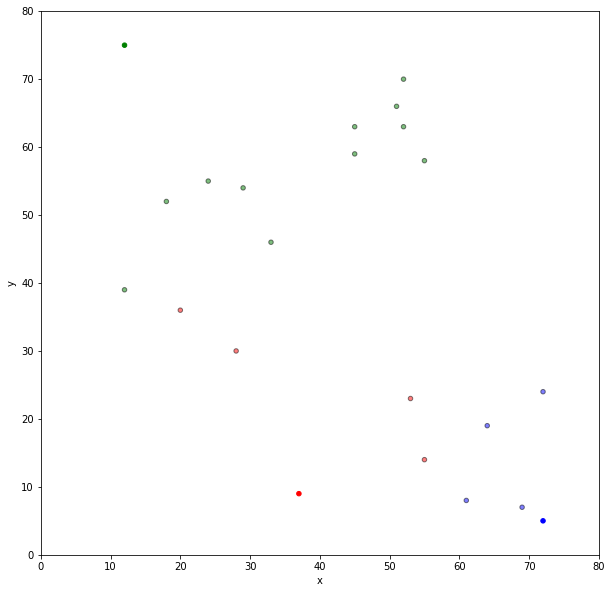

In [202]:
fig, ax2 = plt.subplots(1, figsize=(10,10))
data.plot(kind='scatter',x='x',y='y',color=data['color'],alpha=0.5,edgecolor='k',ax=ax2)
centroids.plot(kind='scatter',x='x',y='y',color=centroids['color'],ax=ax2)

plt.xlim(0,80)
plt.ylim(0,80)
plt.show()

## Update Stage

In [203]:
import copy

old_centroids = copy.deepcopy( centroids )

def update(k):
    centroids = data.groupby('closest').mean()[['x','y']]
    centroids['color'] = old_centroids['color']
    return centroids

centroids = update(centroids)
print(centroids)

                 x          y color
closest                            
0        39.000000  25.750000     r
1        37.818182  56.818182     g
2        66.500000  14.500000     b


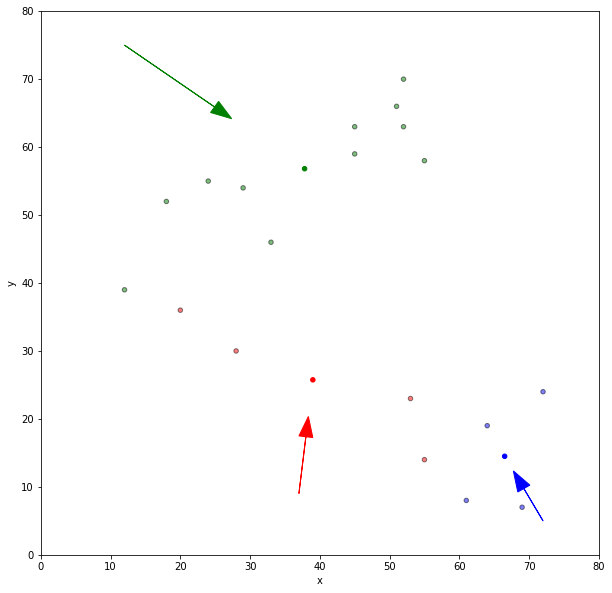

In [204]:
fig, ax3 = plt.subplots(1, figsize=(10,10))

data.plot( kind='scatter' ,ax=ax3, x='x',y='y',color = data['color'] , alpha=0.5 , edgecolor='k')

centroids.plot( kind='scatter' ,ax=ax3, x='x',y='y',color=old_centroids['color'] )

plt.xlim(0,80)
plt.ylim(0,80)

centroid_difference = (centroids[['x','y']] - old_centroids[['x','y']]) * 0.5

for i in range(k):
    ax3.arrow( old_centroids['x'].iloc[i] , old_centroids['y'].iloc[i] , 
             centroid_difference['x'].iloc[i] , centroid_difference['y'].iloc[i],
             head_width=2 , head_length=3 , fc=old_centroids['color'].iloc[i], 
              ec=old_centroids['color'].iloc[i])
    
plt.show()

## Repeat Assignment

In [205]:
data = assignment( data , centroids )

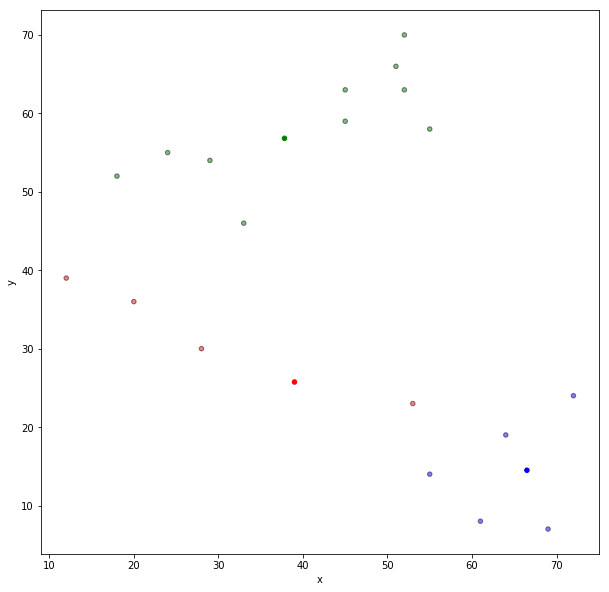

In [206]:
fig, ax4 = plt.subplots(1, figsize=(10,10))
data.plot(kind='scatter',ax=ax4,x='x',y='y',color=data['color'],alpha=0.5,edgecolor='k')
centroids.plot( kind='scatter', ax=ax4,x='x', y='y', color=centroids['color'])
plt.show()

# K-Means Clustering with Scikit-Learn

In [207]:
from sklearn.cluster import KMeans

Fit the KMeans object to our data 

In [208]:
kmeans = KMeans( n_clusters=3 )
kmeans.fit( data[['x','y']].values )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Generate labels by using predict method on our data and retrieve the centroids

In [223]:
labels = kmeans.predict( data[['x','y']].values )
centroids = kmeans.cluster_centers_
print(centroids)

[[62.33333333 15.83333333]
 [23.42857143 44.57142857]
 [50.         63.16666667]]


In [212]:
print(old_centroids['color'])

0    r
1    g
2    b
Name: color, dtype: object


Now map the predicted labels into colors and plot the data points, with their predicted classes and corresponding centroids

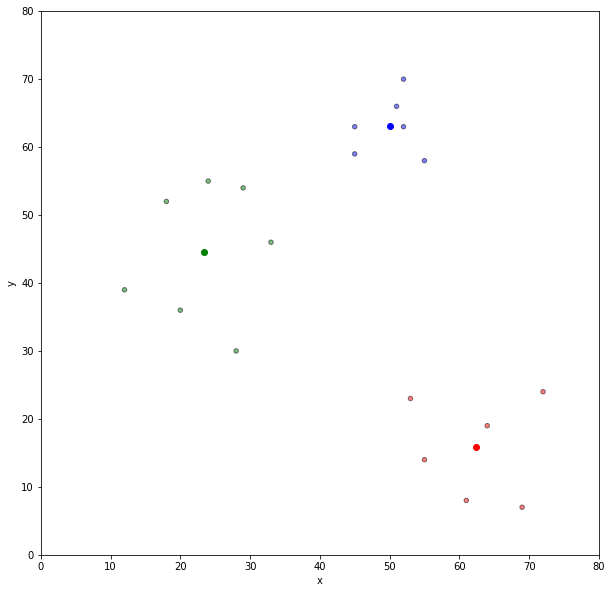

In [222]:
fig, ax5 = plt.subplots(1, figsize=(10,10))
colors = [centroid_colors[label] for label in labels]
data.plot( kind='scatter', ax=ax5,x='x',y='y',color=colors, alpha=0.5, edgecolor='k')
colors=['r','g','b']
for i in range(k):
    ax5.scatter( x=centroids[i][0] , y=centroids[i][1] , color=colors[i])
plt.ylim(0,80)
plt.xlim(0,80)
plt.show()

# Summary
***
K means clustering is very sensitive to scale due to its reliance on Euclidean distance, so be sure to normalize data if there are likely to be scaling problems. 

If there are symmetries in your data, some labels may be mis-labelled

It is recommended to do the same k-means with different initial centroids and take the most common predicted label.